<h1 align="center">Block Statistics</h1>
<h2 align="center">Bruno Gonçalves</h2>
<h4 align="center">bgoncalves@gmail.com</h4>
<h4 align="center">@bgoncalves</h4>

In [1]:
import gzip
import numpy as np
import pandas as pd
import sys
import igraph
from tqdm import tqdm 
import pickle
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Graph Analysis

In principle, the blockchain is just that, a chain. However, since there is no central authority coordinating the efforts of the miners we sometimes end up with two blocks competing for validation at the same time. This results in a temporary fork in the chain. After one of the two competing blocks gets a successor, the losing candidate block is automatically invalidated and its transactions get returned to the mempool.

In [36]:
G = igraph.Graph()
blocks = {}

line_count = 0
block_count = 0

if os.path.exists("data/undirected.pickle"):
    G = igraph.read("data/undirected.pickle")
    blocks = pickle.load(open("data/blocks.pickle", "rb"))
else:
    for line in tqdm(gzip.open('data/blocks.dat.gz', 'rt'), total=566015):
        fields = line.strip().split()

        line_count += 1

        if line_count == 1:
            continue

        # block_count timestamp hash previous_block_hash n_transactions txid reward difficulty bits nonce size
        timestamp = fields[1]
        node_i = fields[2]
        node_j = fields[3]
        ntranx = int(fields[4])
        size = int(fields[-1])

        if node_j not in blocks:
            blocks[node_j] = block_count
            block_count += 1
            node_j = blocks[node_j]
            G.add_vertex(node_j)
        else:
            node_j = blocks[node_j]

        if node_i not in blocks:
            blocks[node_i] = block_count
            block_count += 1
            node_i = blocks[node_i]
            G.add_vertex(node_i)
        else:
            node_i = blocks[node_i]

        G.vs[node_i]["prev"] = node_j,
        G.vs[node_i]["timestamp"] = timestamp,
        G.vs[node_i]["ntrax"] = ntranx,
        G.vs[node_i]["size"] = size

        G.add_edge(node_i, node_j)
    
    G.save('data/undirected.pickle', 'pickle')
    pickle.dump(blocks, open("data/blocks.pickle", "wb"))

In [37]:
G.summary()

'IGRAPH UN-- 566015 566014 -- \n+ attr: name (v), ntrax (v), prev (v), size (v), timestamp (v)'

Here we generated a graph containing all the blocks in order to identify which ones need to be removed. Blocks at the end of a chain have degree 1 (only connecting to the previous block and without any blocks connected to them).

In [38]:
degrees = np.array(G.degree()) # The degree of each block
ids = np.array(G.vs["name"]) # Unique id

dangling = ids[degrees<2] # leaves have degree 1.
dangling = dangling[1:-1] # Remove root and most recent leaf

Starting from these leaf blocks we traverse the graph back until we reach a block with degree higher than two. This is the branch block (one connection to a parent block and at least two child blocks).

In [39]:
remove = []
branches = []

for count, source in enumerate(dangling):
    current = source
    branches.append([])

    while degrees[current] <=2:
        branches[-1].append(current)
        remove.append(current)
        current = G.vs[current]["prev"][0] 

Turns out that all we have are single blocks. There are no parallel chains of greater length.

In [40]:
len(remove) == len(branches)

True

In [41]:
G.delete_vertices(remove)

After we remove the extraneous blocks, we find that we have $N$ nodes connected by $N-1$ edges. A perfect chain.

In [42]:
G.summary()

'IGRAPH UN-- 565964 565963 -- \n+ attr: name (v), ntrax (v), prev (v), size (v), timestamp (v)'

In [116]:
block_ids = [item[0] for item in blocks.items() if item[1] not in remove]

In [117]:
len(block_ids)

565964

In [118]:
block_ids.remove('0000000000000000000000000000000000000000000000000000000000000000') #Remove coinbase

# Clean dataset

In [119]:
data = pd.read_csv('data/blocks.dat.gz', sep=' ', index_col=0)

In [120]:
data.head()

,timestamp,hash,previous_block_hash,n_transactions,txid,reward,difficulty,bits,nonce,size
block_count,,,,,,,,,,
0,1231006505,000000000019d6689c085ae165831e934ff763ae46a2a6...,0000000000000000000000000000000000000000000000...,1,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,5000000000,1.0,486604799,2083236893,285
1,1231469665,00000000839a8e6886ab5951d76f411475428afc90947e...,000000000019d6689c085ae165831e934ff763ae46a2a6...,1,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,5000000000,1.0,486604799,2573394689,215
2,1231469744,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,00000000839a8e6886ab5951d76f411475428afc90947e...,1,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,5000000000,1.0,486604799,1639830024,215
3,1231470173,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,1,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,5000000000,1.0,486604799,1844305925,215
4,1231470988,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,1,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,5000000000,1.0,486604799,2850094635,215


In [121]:
data.dtypes

timestamp                int64
hash                    object
previous_block_hash     object
n_transactions           int64
txid                    object
reward                   int64
difficulty             float64
bits                     int64
nonce                    int64
size                     int64
dtype: object

In [122]:
data.size

5660140

## Remove dangling blocks

In [123]:
data = data.set_index('hash').reindex(block_ids).reset_index().dropna()

In [124]:
data.head()

,hash,timestamp,previous_block_hash,n_transactions,txid,reward,difficulty,bits,nonce,size
0,000000000378457ab84153a2425351a5f4388096d0dffe...,1278237139,00000000070f1a5834e86a8306716f8996752a9bc27ca2...,1,d0d33d13aafba2ddeba00172e5bebb9f2b05c4c0c307c2...,5000000000,1.940480e+01,470626626,241519822,216
1,0000000000000218aaaf48f61598693408303d8d8fc074...,1335831604,0000000000000a57f17bbe39279fdb4996757c25fc19f2...,10,910eb03b277057d80d262fffba76dd1e7660ef65f1e97b...,5000200000,1.508590e+06,436936439,3345554202,3017
2,000000000000000020b9312b04143e00d1d6db7a985bcd...,1411123732,00000000000000001a61ee54acdbbd001875da79872eca...,497,e82054dd2086ce2e6c613da438791c5901f5a5be0fe74a...,2507539665,2.982973e+10,405068777,2775086569,261617
3,000000000000054a5801dee3870560494d949540ba505b...,1314417553,000000000000016621de182bbed7f40415fe98f9dc6111...,63,e1c0902512cb02113b73c8b8a856139fea2b7407e8db07...,5019366401,1.805701e+06,436816518,4241934319,63239
4,0000000000344ce7b827a5da8502e3dd4cff0b77681aaa...,1284000941,00000000002a7559b84f901cfcd8edc99f7700b2e9c495...,3,b5de90257c4b9bba48a1af12c74e0a763f7133450a7f84...,5001000000,7.128849e+02,459009510,2729335466,2293


In [125]:
data.size

5659630

In [126]:
data.index = pd.to_datetime(data['timestamp'].astype('int'), unit='s')

In [127]:
data.head()

,hash,timestamp,previous_block_hash,n_transactions,txid,reward,difficulty,bits,nonce,size
timestamp,,,,,,,,,,
2010-07-04 09:52:19,000000000378457ab84153a2425351a5f4388096d0dffe...,1278237139,00000000070f1a5834e86a8306716f8996752a9bc27ca2...,1,d0d33d13aafba2ddeba00172e5bebb9f2b05c4c0c307c2...,5000000000,1.940480e+01,470626626,241519822,216
2012-05-01 00:20:04,0000000000000218aaaf48f61598693408303d8d8fc074...,1335831604,0000000000000a57f17bbe39279fdb4996757c25fc19f2...,10,910eb03b277057d80d262fffba76dd1e7660ef65f1e97b...,5000200000,1.508590e+06,436936439,3345554202,3017
2014-09-19 10:48:52,000000000000000020b9312b04143e00d1d6db7a985bcd...,1411123732,00000000000000001a61ee54acdbbd001875da79872eca...,497,e82054dd2086ce2e6c613da438791c5901f5a5be0fe74a...,2507539665,2.982973e+10,405068777,2775086569,261617
2011-08-27 03:59:13,000000000000054a5801dee3870560494d949540ba505b...,1314417553,000000000000016621de182bbed7f40415fe98f9dc6111...,63,e1c0902512cb02113b73c8b8a856139fea2b7407e8db07...,5019366401,1.805701e+06,436816518,4241934319,63239
2010-09-09 02:55:41,0000000000344ce7b827a5da8502e3dd4cff0b77681aaa...,1284000941,00000000002a7559b84f901cfcd8edc99f7700b2e9c495...,3,b5de90257c4b9bba48a1af12c74e0a763f7133450a7f84...,5001000000,7.128849e+02,459009510,2729335466,2293


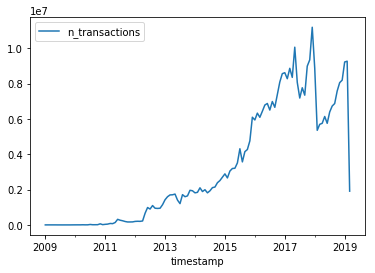

In [128]:
data[['n_transactions']].resample('M').sum().plot()

In [130]:
data['size'].resample('M').mean().max()

1092055.1803278688

In [131]:
1092055/1024/1024

1.0414648056030273